### Question 1
#### (P) Find the top 5 ranked airports in the state of New York. Present results in a similar form to what was done for the state of California|Table 3.6.

In [718]:
datadir = '../Datasets/'

In [719]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

In [720]:
## define the colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

In [721]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
D.head()

,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731


In [722]:
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed=True, edge_attrs=['weight'])
df = D.head()
## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
A.head()

,airport,lon,lat,state,city
0,ABE,-75.440804,40.652100,PA,Allentown
1,ABI,-99.681900,32.411301,TX,Abilene
2,ABQ,-106.609001,35.040199,NM,Albuquerque
3,ABR,-98.421799,45.449100,SD,Aberdeen
4,ABY,-84.194504,31.535500,GA,Albany


In [723]:
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]
g.vs()['layout'] = [(A['lon'][i],A['lat'][i]) for i in l]
g.vs()['state'] = [A['state'][i] for i in l]
g.vs()['city'] = [A['city'][i] for i in l]
## add a few more attributes for visualization
g.vs()['size'] = sz[1]
g.vs()['color'] = cls[1]
g.es()['color'] = cls_edges
g.es()['arrow_size'] = 0.33
A.head()
print(g.vcount(),'nodes and',g.ecount(),'directed edges')

464 nodes and 12000 directed edges


In [724]:
## Build smaller subgraph for New york (you can try other states)
hva = [v for v in g.vs() if v['state'] == 'NY']
G = g.subgraph(hva)
G.vcount()

17

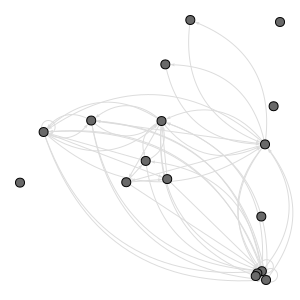

In [725]:
## plot using lat/lon as layout
ly = ig.Layout(G.vs['layout'])
ly.mirror(1)
ig.plot(G, bbox=(0,0,300,300), layout=ly)

In [726]:
## compute normalized weights 
#####weight is the traffic for airport
mw = np.max(G.es['weight'])
G.es()['normalized_weight'] = [w/mw for w in G.es()['weight']]

In [727]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(G.strength(mode='in',weights=weights),\
              G.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in G.strength(weights=weights)]
    return dc

In [728]:
## compute centrality measures
C = pd.DataFrame({'airport':G.vs()['name'],\
                  'degree':degree_centrality(G,weights='normalized_weight'),\
                  'pagerank':G.pagerank(weights='weight'),'authority':G.authority_score(weights='weight'),\
                  'hub':G.hub_score(weights='weight'),'between':G.betweenness(),\
                  'closeness':G.closeness()})
## normalize betweenness
n = G.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality
Cs = C.sort_values(by='degree', ascending=False)
df = Cs.head()
df

,airport,degree,pagerank,authority,hub,between,closeness
0,JFK,0.129888,0.327591,1.000000,0.408982,0.356250,0.188235
2,BUF,0.076250,0.187059,0.285791,1.000000,0.092361,0.188235
4,ROC,0.041181,0.104569,0.154652,0.547064,0.000000,0.183908
5,SYR,0.033720,0.092804,0.124650,0.459323,0.134028,0.190476
1,LGA,0.030048,0.103628,0.213494,0.086202,0.157639,0.190476


### Question 2
#### (P) Generate Chung-Lu graph G(w) on n = 10;000 nodes and power-law degree distribution using the set of weights prescribed by (2.6) with   gamma = 2:5, delta = 1, and traingle =sqreroot(n) = 100. (We experimented with this model in Section 2.5.) For each centrality measure (degree, pagerank, authority, hub, between, closeness) compute f(k), the average centrality measure over all vertices of degree k. Plot f(k) as a function of k. Is there any visible correlation between a given centrality measure and degree of a node?

In [729]:
## fast Chung-Lu: generate m edges w.r.t. distribution d
def fastCL(d, m):
    n = len(d)
    s = np.sum(d)
    p = [i/s for i in d]
    target = m
    tples = []
    while len(tples) < target:
        s = target - len(tples)
        e0 = np.random.choice(n, size=s, replace=True, p=p)
        e1 = np.random.choice(n, size=s, replace=True, p=p)
        tples.extend([(min(e0[i],e1[i]),max(e0[i],e1[i])) for i in range(len(e0)) if e0[i]!=e1[i]]) ## ignore loops
        tples = list(set(tples)) ## drop collisions
    return tples

In [730]:
## power law graph
import numpy as np
gamma = 2.5
n = 10000
delta = 1
Delta = np.sqrt(n)
W = []
for i in np.arange(1,n+1):
    W.append(delta * (n/(i-1+n/(Delta/delta)**(gamma-1)))**(1/(gamma-1)))

deg = [int(np.round(w)) for w in W]


m = int(np.mean(deg)*n/2)
tpl = fastCL(deg,m)

g1 = ig.Graph.TupleList(tpl, directed = True)
g1.es['weight'] = W

In [731]:
## compute normalized weights 
#####weight is the traffic for airport
mw = np.max(g1.es['weight'])
g1.es()['normalized_weight'] = [w/mw for w in g1.es()['weight']]

In [732]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g1.strength(mode='in',weights=weights),\
              g1.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g1.strength(weights=weights)]
    return dc

In [736]:
## compute several centrality measures
C = pd.DataFrame({'name':g1.vs()['name'],\
                  'degree':degree_centrality(g1,weights='normalized_weight'),\
                  'pagerank':g1.pagerank(weights='weight'),'authority':g1.authority_score(weights='weight'),\
                  'hub':g1.hub_score(weights='weight'),'between':g1.betweenness(),\
                  'closeness':g1.closeness()})
## normalize betweenness
n = g1.vcount()
C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality
Cs = C.sort_values(by='degree', ascending=False)

df = Cs
df

,name,degree,pagerank,authority,hub,between,closeness
142,1,2.359872e-04,0.000083,7.483356e-09,1.033251e-04,0.000042,0.003112
166,15,2.030248e-04,0.000084,6.635832e-08,1.581345e-05,0.000106,0.003109
345,3,1.855672e-04,0.000082,0.000000e+00,1.873514e-06,0.000000,0.003111
266,14,1.628369e-04,0.000087,3.890461e-07,1.784770e-05,0.000299,0.003111
190,0,1.625553e-04,0.000082,0.000000e+00,6.486359e-07,0.000000,0.003111
...,...,...,...,...,...,...,...
7059,4852,6.383744e-07,0.000106,2.473011e-13,0.000000e+00,0.000000,0.003085
7062,8098,6.381185e-07,0.000212,0.000000e+00,0.000000e+00,0.000000,0.003080
7063,7732,6.378203e-07,0.000090,2.674027e-12,0.000000e+00,0.000000,0.003090
7064,5339,6.377777e-07,0.000082,0.000000e+00,0.000000e+00,0.000000,0.003078


In [737]:
deg = g1.degree()
d5 = pd.DataFrame(deg)
df

,name,degree,pagerank,authority,hub,between,closeness
142,1,2.359872e-04,0.000083,7.483356e-09,1.033251e-04,0.000042,0.003112
166,15,2.030248e-04,0.000084,6.635832e-08,1.581345e-05,0.000106,0.003109
345,3,1.855672e-04,0.000082,0.000000e+00,1.873514e-06,0.000000,0.003111
266,14,1.628369e-04,0.000087,3.890461e-07,1.784770e-05,0.000299,0.003111
190,0,1.625553e-04,0.000082,0.000000e+00,6.486359e-07,0.000000,0.003111
...,...,...,...,...,...,...,...
7059,4852,6.383744e-07,0.000106,2.473011e-13,0.000000e+00,0.000000,0.003085
7062,8098,6.381185e-07,0.000212,0.000000e+00,0.000000e+00,0.000000,0.003080
7063,7732,6.378203e-07,0.000090,2.674027e-12,0.000000e+00,0.000000,0.003090
7064,5339,6.377777e-07,0.000082,0.000000e+00,0.000000e+00,0.000000,0.003078


In [738]:
d5['deg'] = d5[0]
d5['name'] = g1.vs()['name']
del d5[0]
d6 = d5.merge(Cs)
d7 = d6.groupby('deg').agg({"degree":'mean',"pagerank":'mean','authority': 'mean','hub': 'mean', 'between': 'mean', 'closeness': 'mean' }).reset_index()
d7

,deg,degree,pagerank,authority,hub,between,closeness
0,1,0.000002,0.000114,1.417481e-05,7.166089e-09,0.000000e+00,0.002773
1,2,0.000004,0.000137,9.120518e-06,6.705338e-08,2.341817e-07,0.003047
2,3,0.000006,0.000144,9.281302e-04,1.202061e-07,8.133141e-07,0.003090
3,4,0.000008,0.000148,3.967945e-06,3.379196e-08,1.843783e-06,0.003097
4,5,0.000011,0.000139,2.244926e-06,3.874037e-05,3.221964e-06,0.003098
...,...,...,...,...,...,...,...
57,78,0.000148,0.000083,7.197615e-09,1.613421e-06,2.659412e-05,0.003111
58,93,0.000163,0.000082,0.000000e+00,6.486359e-07,0.000000e+00,0.003111
59,94,0.000159,0.000084,4.375925e-06,3.853159e-07,1.213957e-04,0.003112
60,97,0.000186,0.000082,0.000000e+00,1.873514e-06,0.000000e+00,0.003111


### Correlation between degree of node and closeness

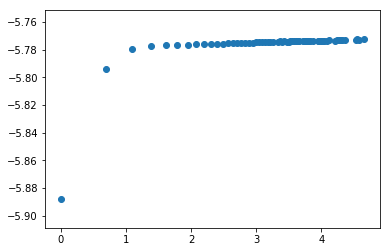

In [739]:
plt.scatter(np.log(d7['deg']),np.log(d7['closeness']))

The graph shows positive correaltion between degree of nodes and closeness centrality measure

### Correlation between degree of node and pagerank

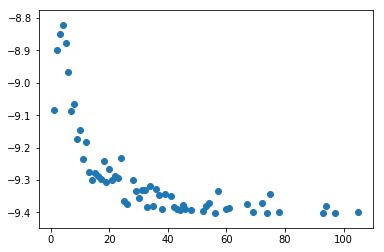

In [740]:
plt.scatter(d7['deg'],np.log(d7['pagerank']))

The graph shows negative correaltion between degree of nodes and pagerank centrality measure

### Correlation between degree of node and betweenness centrality measure

/Users/user/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


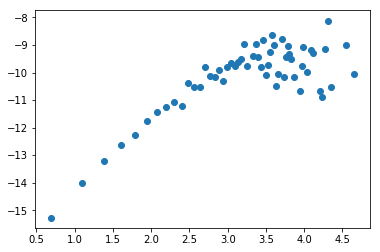

In [741]:
plt.scatter(np.log(d7['deg']),np.log(d7['between']))

The graph shows positive correaltion between degree of nodes and betwenness centrality measure

### Correlation between degree of node and hub centrality measure

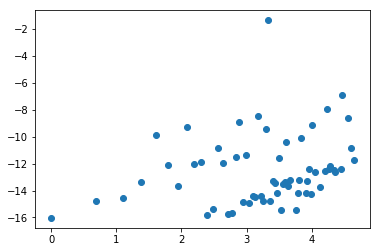

In [658]:
plt.scatter(np.log(d7['deg']),np.log(d7['hub']))

The graph shows low negative correaltion between degree of nodes and hub centrality measure

### Correlation between degree of node and authority centrality measure

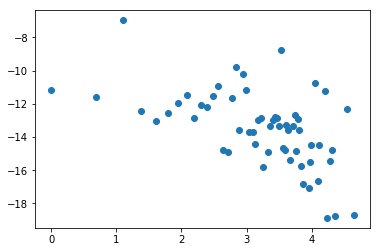

In [743]:
plt.scatter(np.log(d7['deg']),np.log(d7['authority']))

The graph shows low negative correaltion between degree of nodes and authority centrality measure

### Correlation between degree of node and degree centrality measure

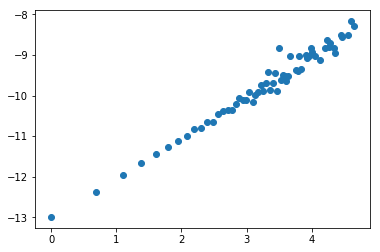

In [665]:
plt.scatter(np.log(d7['deg']),np.log(d7['degree']))

The graph shows highly positive correaltion between degree of nodes and degree centrality measure

### Question 3
#### The original airport dataset (464 nodes, 12{,}000 directed weighted edges) is not strongly connected but it is almost weakly connected. There are two weak components: the giant one consisting of all but two airports, and the small one with two airports that only link to each other. Remove the two nodes to make the graph weakly connected. For each centrality measure (degree, pagerank, authority, hub, between, closeness) perform the following experiment. Sort all nodes with respect to a given centrality measure. How many nodes with the largest score do we need to remove to so that the graph is no longer weakly connected? Compare this with the number of nodes with the smallest score that need to be removed.

In [680]:
## define the colors and node sizes here
cls_edges = 'gainsboro'
cls = ['silver','dimgray','black']
sz = [6,9,12]

In [681]:
## read edges and build weighted directed graph
D = pd.read_csv(datadir+'Airports/connections.csv')
D.head()

,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731


In [682]:
D.drop_duplicates(subset = ['orig_airport', 'dest_airport'])

,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731
...,...,...,...
11995,RDD,CEC,1
11996,ALB,OKC,1
11997,IND,SLC,1
11998,FTY,FXE,1


In [688]:
g = ig.Graph.TupleList([tuple(x) for x in D.values], directed = True, edge_attrs = ['weight'])
g.vcount()

464

In [689]:
a = [len(c) for c in sorted(g.components(mode = "weak"))]
a

[462, 2]

In [690]:
g.delete_vertices([462,2])
g.vcount()

462

In [691]:
## read vertex attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
A.head()

,airport,lon,lat,state,city
0,ABE,-75.440804,40.652100,PA,Allentown
1,ABI,-99.681900,32.411301,TX,Abilene
2,ABQ,-106.609001,35.040199,NM,Albuquerque
3,ABR,-98.421799,45.449100,SD,Aberdeen
4,ABY,-84.194504,31.535500,GA,Albany


In [692]:
## compute normalized weights 
#####weight is the traffic for airport
mw = np.max(g.es['weight'])
g.es()['normalized_weight'] = [w/mw for w in g.es()['weight']]

In [693]:
## directed degree centrality
def degree_centrality(g, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(g.strength(mode='in',weights=weights),\
              g.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in g.strength(weights=weights)]
    return dc

In [704]:
## compute several centrality measures
C = pd.DataFrame({'airport':g.vs()['name'],\
                  'degree':degree_centrality(g,weights='normalized_weight'),\
                  'pagerank':g.pagerank(weights='weight'),'authority':g.authority_score(weights='weight'),\
                  'hub':g.hub_score(weights='weight'),'between':g.betweenness(),\
                  'closeness':g.closeness()})
## normalize betweenness
n = g.vcount()

C['between'] = [2*x/((n-1)*(n-2)) for x in C['between']]
## sort w.r.t. degree centrality
Cs = C.sort_values(by='degree', ascending=True)
df = Cs
df.head()

,airport,degree,pagerank,authority,hub,between,closeness
305,RDG,0.000000e+00,0.000339,0.000000e+00,0.000000e+00,0.0,0.002165
461,EKX,7.520941e-10,0.000339,0.000000e+00,3.434554e-12,0.0,0.163244
460,WVL,7.520941e-10,0.000626,0.000000e+00,0.000000e+00,0.0,0.002169
459,DET,7.520941e-10,0.000339,0.000000e+00,0.000000e+00,0.0,0.002169
456,FDY,1.504188e-09,0.000339,4.706781e-08,0.000000e+00,0.0,0.174094


#### sorting nodes to connect the graphs using degree as centreality measure

In [695]:
ds1 = D.copy()
df = df.sort_values(by='degree', ascending=True)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([462,2])
for i, row in df.iterrows():
    air = row['airport']
    print(g2.vcount())
    if g2.is_connected() == False:
        print('deleting', air)
        print(g2.vcount())
        g2.delete_vertices(air)
        print(g2.is_connected())
    elif g2.is_connected() == True:
        g3 = g2.copy()
        print(g2.vcount())
        print('Connected.................................................. with nodes',g2.vcount() )

462
deleting RDG
462
False
461
deleting DET
461
False
460
deleting EKX
460
False
459
deleting WVL
459
False
458
deleting FDY
458
False
457
deleting ADS
457
False
456
deleting MTN
456
False
455
deleting MOP
455
False
454
deleting TKF
454
False
453
deleting WGO
453
False
452
deleting AUO
452
False
451
deleting APC
451
False
450
deleting FTY
450
False
449
deleting GFL
449
False
448
deleting AGC
448
False
447
deleting ESN
447
False
446
deleting MRI
446
False
445
deleting SDM
445
False
444
deleting POU
444
False
443
deleting THV
443
False
442
deleting ISM
442
False
441
deleting JEF
441
False
440
deleting DWH
440
False
439
deleting STP
439
False
438
deleting MGY
438
False
437
deleting GUS
437
False
436
deleting SKA
436
False
435
deleting HSH
435
False
434
deleting FXE
434
False
433
deleting ORL
433
False
432
deleting PDK
432
False
431
deleting MCF
431
False
430
deleting PNE
430
False
429
deleting PWK
429
False
428
deleting IAB
428
False
427
deleting NQX
427
False
426
deleting OWB
426
False
4

393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393


393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393


393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393
Connected.................................................. with nodes 393
393
393


In [705]:
ds1 = D.copy()
df = df.sort_values(by='degree', ascending=False)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([462,2])
for i, row in df.iterrows():
    air = row['airport']
    print(g2.vcount())
    if g2.is_connected() == False:
        print('deleting', air)
        print(g2.vcount())
        g2.delete_vertices(air)
        print(g2.is_connected())
    elif g2.is_connected() == True:
        g3 = g2.copy()
        print(g2.vcount())
        print('Connected.................................................. with nodes',g2.vcount() )

462
deleting ATL
462
False
461
deleting ORD
461
False
460
deleting DFW
460
False
459
deleting LAX
459
False
458
deleting LAS
458
False
457
deleting PHX
457
False
456
deleting CLT
456
False
455
deleting IAH
455
False
454
deleting MSP
454
False
453
deleting DTW
453
False
452
deleting SEA
452
False
451
deleting SFO
451
False
450
deleting PHL
450
False
449
deleting JFK
449
False
448
deleting EWR
448
False
447
deleting LGA
447
False
446
deleting BOS
446
False
445
deleting BWI
445
False
444
deleting SAN
444
False
443
deleting FLL
443
False
442
deleting SLC
442
False
441
deleting TPA
441
False
440
deleting DCA
440
False
439
deleting MDW
439
False
438
deleting IAD
438
False
437
deleting MIA
437
False
436
deleting STL
436
False
435
deleting PDX
435
False
434
deleting CVG
434
False
433
deleting HNL
433
False
432
deleting MCI
432
False
431
deleting MEM
431
False
430
deleting CLE
430
False
429
deleting RDU
429
False
428
deleting DAL
428
False
427
deleting BNA
427
False
426
deleting OAK
426
False
4

30
deleting ORL
30
False
29
deleting FXE
29
False
28
deleting HSH
28
False
27
deleting SKA
27
False
26
deleting GUS
26
False
25
deleting MGY
25
False
24
deleting STP
24
False
23
deleting JEF
23
False
22
deleting DWH
22
False
21
deleting ISM
21
False
20
deleting POU
20
False
19
deleting THV
19
False
18
deleting SDM
18
False
17
deleting MRI
17
False
16
deleting ESN
16
False
15
deleting AGC
15
False
14
deleting GFL
14
False
13
deleting FTY
13
False
12
deleting APC
12
False
11
deleting AUO
11
False
10
deleting WGO
10
False
9
deleting TKF
9
False
8
deleting ADS
8
False
7
deleting MOP
7
False
6
deleting FDY
6
False
5
deleting MTN
5
False
4
deleting WVL
4
False
3
deleting EKX
3
False
2
deleting DET
2
True
1
1
Connected.................................................. with nodes 1


#### Number of nodes with the largest score for degree centrality that we removed so that the graph is no longer weakly connected is 462 and with smallest score it is 69

#### sorting nodes to connect the graphs using pagerank as centreality measure

In [706]:
ds1 = D.copy()
df = df.sort_values(by='pagerank', ascending=True)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([462,2])
for i, row in df.iterrows():
    air = row['airport']
    print(g2.vcount())
    if g2.is_connected() == False:
        print('deleting', air)
        print(g2.vcount())
        g2.delete_vertices(air)
        print(g2.is_connected())
    elif g2.is_connected() == True:
        g3 = g2.copy()
        print(g2.vcount())
        print('Connected.................................................. with nodes',g2.vcount() )

462
deleting RDG
462
False
461
deleting GSB
461
False
460
deleting MHR
460
False
459
deleting FFO
459
False
458
deleting STJ
458
False
457
deleting LAL
457
False
456
deleting EDF
456
False
455
deleting DNE
455
False
454
deleting OWB
454
False
453
deleting NFL
453
False
452
deleting SKA
452
False
451
deleting DET
451
False
450
deleting MIB
450
False
449
deleting EKX
449
False
448
deleting MTN
448
False
447
deleting ADS
447
False
446
deleting AGC
446
False
445
deleting TKF
445
False
444
deleting GFL
444
False
443
deleting AUO
443
False
442
deleting FDY
442
False
441
deleting MRI
441
False
440
deleting SDM
440
False
439
deleting FTY
439
False
438
deleting JEF
438
False
437
deleting ESN
437
False
436
deleting APC
436
False
435
deleting PNE
435
False
434
deleting MOP
434
False
433
deleting HSH
433
False
432
deleting ORL
432
False
431
deleting THV
431
False
430
deleting ISM
430
False
429
deleting PWK
429
False
428
deleting MGY
428
False
427
deleting MCF
427
False
426
deleting SCF
426
False
4

False
135
deleting GRK
135
False
134
deleting TLH
134
False
133
deleting GRB
133
False
132
deleting AMA
132
False
131
deleting MHK
131
False
130
deleting FNT
130
False
129
deleting POU
129
False
128
deleting BTR
128
False
127
deleting FSD
127
False
126
deleting ABE
126
False
125
deleting RDD
125
False
124
deleting MAF
124
False
123
deleting SLN
123
False
122
deleting GCK
122
False
121
deleting SZL
121
False
120
deleting EAR
120
False
119
deleting ITO
119
False
118
deleting LEX
118
False
117
deleting CAK
117
False
116
deleting VGT
116
False
115
deleting SGF
115
False
114
deleting HSV
114
False
113
deleting FAI
113
False
112
deleting ATY
112
False
111
deleting MDT
111
False
110
deleting XNA
110
False
109
deleting CID
109
False
108
deleting CLM
108
False
107
deleting PIR
107
False
106
deleting LBL
106
False
105
deleting ACY
105
False
104
deleting BAD
104
False
103
deleting LBB
103
False
102
deleting GPT
102
False
101
deleting GCC
101
False
100
deleting JAN
100
False
99
deleting ICT
99
Fal

In [707]:
ds1 = D.copy()
df = df.sort_values(by='pagerank', ascending=False)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([462,2])
for i, row in df.iterrows():
    air = row['airport']
    print(g2.vcount())
    if g2.is_connected() == False:
        print('deleting', air)
        print(g2.vcount())
        g2.delete_vertices(air)
        print(g2.is_connected())
    elif g2.is_connected() == True:
        g3 = g2.copy()
        print(g2.vcount())
        print('Connected.................................................. with nodes',g2.vcount() )

462
deleting ATL
462
False
461
deleting ORD
461
False
460
deleting DFW
460
False
459
deleting LAX
459
False
458
deleting LAS
458
False
457
deleting PHX
457
False
456
deleting MSP
456
False
455
deleting IAH
455
False
454
deleting CLT
454
False
453
deleting DTW
453
False
452
deleting SEA
452
False
451
deleting SFO
451
False
450
deleting PHL
450
False
449
deleting SLC
449
False
448
deleting EWR
448
False
447
deleting BOS
447
False
446
deleting JFK
446
False
445
deleting LGA
445
False
444
deleting IAD
444
False
443
deleting BWI
443
False
442
deleting TPA
442
False
441
deleting FLL
441
False
440
deleting SAN
440
False
439
deleting DCA
439
False
438
deleting STL
438
False
437
deleting MDW
437
False
436
deleting MIA
436
False
435
deleting MCI
435
False
434
deleting MEM
434
False
433
deleting PDX
433
False
432
deleting CVG
432
False
431
deleting HNL
431
False
430
deleting DAL
430
False
429
deleting CLE
429
False
428
deleting BNA
428
False
427
deleting RDU
427
False
426
deleting OAK
426
False
4

False
147
deleting HVN
147
False
146
deleting MOD
146
False
145
deleting DRO
145
False
144
deleting EKO
144
False
143
deleting LCK
143
False
142
deleting BPT
142
False
141
deleting EAU
141
False
140
deleting BQK
140
False
139
deleting PAH
139
False
138
deleting BJI
138
False
137
deleting LNS
137
False
136
deleting LMT
136
False
135
deleting GGG
135
False
134
deleting PRC
134
False
133
deleting JMS
133
False
132
deleting CIC
132
False
131
deleting STC
131
False
130
deleting IPT
130
False
129
deleting AHN
129
False
128
deleting UIN
128
False
127
deleting PIB
127
False
126
deleting BRL
126
False
125
deleting IPL
125
False
124
deleting JHW
124
False
123
deleting MEI
123
False
122
deleting TCM
122
False
121
deleting SUS
121
False
120
deleting ALM
120
False
119
deleting DRT
119
False
118
deleting VEL
118
False
117
deleting ORH
117
False
116
deleting CEC
116
False
115
deleting OXR
115
False
114
deleting MWA
114
False
113
deleting APN
113
False
112
deleting GYY
112
False
111
deleting CDC
111
F

#### Number of nodes with the largest score for pagerank centrality that we removed so that the graph is no longer weakly connected is 461 and with smallest score it is 413

#### sorting nodes to connect the graphs using authority as centreality measure

In [708]:
ds1 = D.copy()
df = df.sort_values(by='authority', ascending=True)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([462,2])
for i, row in df.iterrows():
    air = row['airport']
    print(g2.vcount())
    if g2.is_connected() == False:
        print('deleting', air)
        print(g2.vcount())
        g2.delete_vertices(air)
        print(g2.is_connected())
    elif g2.is_connected() == True:
        g3 = g2.copy()
        print(g2.vcount())
        print('Connected.................................................. with nodes',g2.vcount() )

462
deleting RDG
462
False
461
deleting WGO
461
False
460
deleting WVL
460
False
459
deleting RCA
459
False
458
deleting GFL
458
False
457
deleting LAL
457
False
456
deleting OWB
456
False
455
deleting EDF
455
False
454
deleting SKA
454
False
453
deleting STJ
453
False
452
deleting FFO
452
False
451
deleting DNE
451
False
450
deleting NFL
450
False
449
deleting TKF
449
False
448
deleting AGC
448
False
447
deleting MHR
447
False
446
deleting MTN
446
False
445
deleting ADS
445
False
444
deleting GSB
444
False
443
deleting EKX
443
False
442
deleting DET
442
False
441
deleting MIB
441
False
440
deleting MVW
440
False
439
deleting DWH
439
False
438
deleting PWT
438
False
437
deleting TIK
437
False
436
deleting SZL
436
False
435
deleting SEE
435
False
434
deleting POU
434
False
433
deleting BAD
433
False
432
deleting VAD
432
False
431
deleting GUS
431
False
430
deleting BTL
430
False
429
deleting LBF
429
False
428
deleting AMW
428
False
427
deleting DIK
427
False
426
deleting MRI
426
False
4

341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341


341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341
Connected.................................................. with nodes 341
341
341


In [709]:
ds1 = D.copy()
df = df.sort_values(by='authority', ascending=False)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([462,2])
for i, row in df.iterrows():
    air = row['airport']
    print(g2.vcount())
    if g2.is_connected() == False:
        print('deleting', air)
        print(g2.vcount())
        g2.delete_vertices(air)
        print(g2.is_connected())
    elif g2.is_connected() == True:
        g3 = g2.copy()
        print(g2.vcount())
        print('Connected.................................................. with nodes',g2.vcount() )

462
deleting ATL
462
False
461
deleting ORD
461
False
460
deleting LAX
460
False
459
deleting DFW
459
False
458
deleting LAS
458
False
457
deleting PHX
457
False
456
deleting SFO
456
False
455
deleting MSP
455
False
454
deleting SEA
454
False
453
deleting IAH
453
False
452
deleting DTW
452
False
451
deleting CLT
451
False
450
deleting PHL
450
False
449
deleting EWR
449
False
448
deleting JFK
448
False
447
deleting BOS
447
False
446
deleting LGA
446
False
445
deleting SAN
445
False
444
deleting FLL
444
False
443
deleting MIA
443
False
442
deleting DCA
442
False
441
deleting TPA
441
False
440
deleting SLC
440
False
439
deleting BWI
439
False
438
deleting IAD
438
False
437
deleting STL
437
False
436
deleting MDW
436
False
435
deleting PDX
435
False
434
deleting HNL
434
False
433
deleting MCI
433
False
432
deleting RDU
432
False
431
deleting SNA
431
False
430
deleting PIT
430
False
429
deleting SJC
429
False
428
deleting CLE
428
False
427
deleting SMF
427
False
426
deleting CVG
426
False
4

141
deleting HRO
141
False
140
deleting LGU
140
False
139
deleting YNG
139
False
138
deleting LAR
138
False
137
deleting FOD
137
False
136
deleting IRK
136
False
135
deleting CPS
135
False
134
deleting ILG
134
False
133
deleting NIP
133
False
132
deleting EIL
132
False
131
deleting BWG
131
False
130
deleting MWH
130
False
129
deleting FYV
129
False
128
deleting YIP
128
False
127
deleting LUK
127
False
126
deleting CGI
126
False
125
deleting DDC
125
False
124
deleting TCM
124
False
123
deleting HOB
123
False
122
deleting MDH
122
False
121
deleting DYS
121
False
120
deleting GYY
120
False
119
deleting FTW
119
False
118
deleting LBL
118
False
117
deleting RIV
117
False
116
deleting RUI
116
False
115
deleting NQA
115
False
114
deleting MKL
114
False
113
deleting AND
113
False
112
deleting BIF
112
False
111
deleting HUF
111
False
110
deleting DOV
110
False
109
deleting MFD
109
False
108
deleting ALM
108
False
107
deleting ORH
107
False
106
deleting JBR
106
False
105
deleting ART
105
False
1

#### Number of nodes with the largest score for degree centrality that we removed so that the graph is no longer weakly connected is 461 and with smallest score it is 121

In [ ]:
#### sorting nodes to connect the graphs using hub as centreality measure

In [710]:
ds1 = D.copy()
df = df.sort_values(by='hub', ascending=True)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([462,2])
for i, row in df.iterrows():
    air = row['airport']
    print(g2.vcount())
    if g2.is_connected() == False:
        print('deleting', air)
        print(g2.vcount())
        g2.delete_vertices(air)
        print(g2.is_connected())
    elif g2.is_connected() == True:
        g3 = g2.copy()
        print(g2.vcount())
        print('Connected.................................................. with nodes',g2.vcount() )

462
deleting RDG
462
False
461
deleting ESN
461
False
460
deleting IAB
460
False
459
deleting NBG
459
False
458
deleting NQX
458
False
457
deleting GUS
457
False
456
deleting SZL
456
False
455
deleting DWH
455
False
454
deleting SKA
454
False
453
deleting MCC
453
False
452
deleting ISM
452
False
451
deleting LSF
451
False
450
deleting FDY
450
False
449
deleting MOP
449
False
448
deleting DET
448
False
447
deleting MCF
447
False
446
deleting MGY
446
False
445
deleting WGO
445
False
444
deleting DYS
444
False
443
deleting ANB
443
False
442
deleting WVL
442
False
441
deleting HIF
441
False
440
deleting DNE
440
False
439
deleting TIK
439
False
438
deleting MVW
438
False
437
deleting PWT
437
False
436
deleting PDK
436
False
435
deleting NFL
435
False
434
deleting EKX
434
False
433
deleting SEE
433
False
432
deleting MIB
432
False
431
deleting BAD
431
False
430
deleting VAD
430
False
429
deleting POU
429
False
428
deleting GSB
428
False
427
deleting STF
427
False
426
deleting EDF
426
False
4

357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357


357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357


357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357
357
357
Connected.................................................. with nodes 357


In [711]:
ds1 = D.copy()
df = df.sort_values(by='hub', ascending=False)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([462,2])
for i, row in df.iterrows():
    air = row['airport']
    print(g2.vcount())
    if g2.is_connected() == False:
        print('deleting', air)
        print(g2.vcount())
        g2.delete_vertices(air)
        print(g2.is_connected())
    elif g2.is_connected() == True:
        g3 = g2.copy()
        print(g2.vcount())
        print('Connected.................................................. with nodes',g2.vcount() )

462
deleting ATL
462
False
461
deleting ORD
461
False
460
deleting LAX
460
False
459
deleting DFW
459
False
458
deleting LAS
458
False
457
deleting PHX
457
False
456
deleting SFO
456
False
455
deleting MSP
455
False
454
deleting SEA
454
False
453
deleting IAH
453
False
452
deleting CLT
452
False
451
deleting DTW
451
False
450
deleting PHL
450
False
449
deleting EWR
449
False
448
deleting JFK
448
False
447
deleting BOS
447
False
446
deleting LGA
446
False
445
deleting FLL
445
False
444
deleting SAN
444
False
443
deleting MIA
443
False
442
deleting DCA
442
False
441
deleting TPA
441
False
440
deleting SLC
440
False
439
deleting BWI
439
False
438
deleting IAD
438
False
437
deleting STL
437
False
436
deleting MDW
436
False
435
deleting PDX
435
False
434
deleting HNL
434
False
433
deleting MCI
433
False
432
deleting RDU
432
False
431
deleting SNA
431
False
430
deleting PIT
430
False
429
deleting SJC
429
False
428
deleting SMF
428
False
427
deleting CLE
427
False
426
deleting CVG
426
False
4

#### Number of nodes with the largest score for hub centrality that we removed so that the graph is no longer weakly connected is 461 and with smallest score it is 105

In [745]:
#### sorting nodes to connect the graphs using betweenness as centreality measure

In [712]:
ds1 = D.copy()
df = df.sort_values(by='between', ascending=True)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([462,2])
for i, row in df.iterrows():
    air = row['airport']
    print(g2.vcount())
    if g2.is_connected() == False:
        print('deleting', air)
        print(g2.vcount())
        g2.delete_vertices(air)
        print(g2.is_connected())
    elif g2.is_connected() == True:
        g3 = g2.copy()
        print(g2.vcount())
        print('Connected.................................................. with nodes',g2.vcount() )

462
deleting RDG
462
False
461
deleting MIE
461
False
460
deleting LAL
460
False
459
deleting OXR
459
False
458
deleting OGS
458
False
457
deleting ART
457
False
456
deleting MHR
456
False
455
deleting MKL
455
False
454
deleting OWB
454
False
453
deleting ARA
453
False
452
deleting WFB
452
False
451
deleting CIC
451
False
450
deleting NEW
450
False
449
deleting ORL
449
False
448
deleting SDM
448
False
447
deleting CLM
447
False
446
deleting AOO
446
False
445
deleting AGC
445
False
444
deleting ODW
444
False
443
deleting FFO
443
False
442
deleting HIF
442
False
441
deleting APC
441
False
440
deleting NQA
440
False
439
deleting MDH
439
False
438
deleting MGW
438
False
437
deleting RUT
437
False
436
deleting TSS
436
False
435
deleting PKB
435
False
434
deleting AUG
434
False
433
deleting SOW
433
False
432
deleting JHW
432
False
431
deleting VCT
431
False
430
deleting ADQ
430
False
429
deleting IMT
429
False
428
deleting MCE
428
False
427
deleting AFW
427
False
426
deleting GUP
426
False
4

126
False
125
deleting ABE
125
False
124
deleting JAN
124
False
123
deleting SBN
123
False
122
deleting LBB
122
False
121
deleting PVD
121
False
120
deleting PUB
120
False
119
deleting TIK
119
False
118
deleting PAM
118
False
117
deleting RCA
117
True
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
1

Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Connected.................................................. with nodes 116
116
116
Conn

In [713]:
ds1 = D.copy()
df = df.sort_values(by='between', ascending=False)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([462,2])
for i, row in df.iterrows():
    air = row['airport']
    print(g2.vcount())
    if g2.is_connected() == False:
        print('deleting', air)
        print(g2.vcount())
        g2.delete_vertices(air)
        print(g2.is_connected())
    elif g2.is_connected() == True:
        g3 = g2.copy()
        print(g2.vcount())
        print('Connected.................................................. with nodes',g2.vcount() )

462
deleting MSP
462
False
461
deleting LAS
461
False
460
deleting ATL
460
False
459
deleting SLC
459
False
458
deleting PHX
458
False
457
deleting IAD
457
False
456
deleting MCI
456
False
455
deleting SEA
455
False
454
deleting DFW
454
False
453
deleting OKC
453
False
452
deleting ORD
452
False
451
deleting STL
451
False
450
deleting ABQ
450
False
449
deleting PHL
449
False
448
deleting LAX
448
False
447
deleting BFI
447
False
446
deleting CLT
446
False
445
deleting DTW
445
False
444
deleting IAH
444
False
443
deleting BOS
443
False
442
deleting BWI
442
False
441
deleting MDW
441
False
440
deleting MEM
440
False
439
deleting SFO
439
False
438
deleting MKE
438
False
437
deleting PDX
437
False
436
deleting LSV
436
False
435
deleting RNO
435
False
434
deleting RFD
434
False
433
deleting MIA
433
False
432
deleting SAN
432
False
431
deleting ALB
431
False
430
deleting PIT
430
False
429
deleting CMH
429
False
428
deleting ELP
428
False
427
deleting IND
427
False
426
deleting CYS
426
False
4

#### Number of nodes with the largest score for betweeness centrality that we removed so that the graph is no longer weakly connected is 461 and with smallest score it is 346

In [ ]:
#### sorting nodes to connect the graphs using closeness as centreality measure

In [714]:
ds1 = D.copy()
df = df.sort_values(by='closeness', ascending=True)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([462,2])
for i, row in df.iterrows():
    air = row['airport']
    print(g2.vcount())
    if g2.is_connected() == False:
        print('deleting', air)
        print(g2.vcount())
        g2.delete_vertices(air)
        print(g2.is_connected())
    elif g2.is_connected() == True:
        g3 = g2.copy()
        print(g2.vcount())
        print('Connected.................................................. with nodes',g2.vcount() )

462
deleting RDG
462
False
461
deleting DET
461
False
460
deleting WVL
460
False
459
deleting DNE
459
False
458
deleting WGO
458
False
457
deleting PWT
457
False
456
deleting MVW
456
False
455
deleting SEE
455
False
454
deleting SKA
454
False
453
deleting EDF
453
False
452
deleting SZL
452
False
451
deleting GSB
451
False
450
deleting HON
450
False
449
deleting MIB
449
False
448
deleting VAD
448
False
447
deleting BAD
447
False
446
deleting TIK
446
False
445
deleting WFB
445
False
444
deleting DWH
444
False
443
deleting NFL
443
False
442
deleting AMW
442
False
441
deleting GUS
441
False
440
deleting ANB
440
False
439
deleting MCC
439
False
438
deleting POU
438
False
437
deleting FFO
437
False
436
deleting FBK
436
False
435
deleting ISM
435
False
434
deleting ADS
434
False
433
deleting ISN
433
False
432
deleting EKX
432
False
431
deleting IAB
431
False
430
deleting MCF
430
False
429
deleting DIK
429
False
428
deleting HGR
428
False
427
deleting MOP
427
False
426
deleting ADQ
426
False
4

321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321


321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321


321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321
Connected.................................................. with nodes 321
321
321


In [715]:
ds1 = D.copy()
df = df.sort_values(by='closeness', ascending=False)
g2 = ig.Graph.TupleList([tuple(x) for x in ds1.values], directed = True)
g2.delete_vertices([462,2])
for i, row in df.iterrows():
    air = row['airport']
    print(g2.vcount())
    if g2.is_connected() == False:
        print('deleting', air)
        print(g2.vcount())
        g2.delete_vertices(air)
        print(g2.is_connected())
    elif g2.is_connected() == True:
        g3 = g2.copy()
        print(g2.vcount())
        print('Connected.................................................. with nodes',g2.vcount() )

462
deleting ORD
462
False
461
deleting MSP
461
False
460
deleting ATL
460
False
459
deleting IAD
459
False
458
deleting LAS
458
False
457
deleting DFW
457
False
456
deleting DTW
456
False
455
deleting SLC
455
False
454
deleting PHX
454
False
453
deleting MDW
453
False
452
deleting CVG
452
False
451
deleting PHL
451
False
450
deleting CLE
450
False
449
deleting IAH
449
False
448
deleting MEM
448
False
447
deleting STL
447
False
446
deleting CLT
446
False
445
deleting OKC
445
False
444
deleting LAX
444
False
443
deleting MCI
443
False
442
deleting LGA
442
False
441
deleting BWI
441
False
440
deleting IND
440
False
439
deleting BNA
439
False
438
deleting BOS
438
False
437
deleting PIT
437
False
436
deleting CMH
436
False
435
deleting MKE
435
False
434
deleting SEA
434
False
433
deleting EWR
433
False
432
deleting MSY
432
False
431
deleting AUS
431
False
430
deleting SAT
430
False
429
deleting SFO
429
False
428
deleting OMA
428
False
427
deleting SAN
427
False
426
deleting FLL
426
False
4

129
deleting HSH
129
False
128
deleting BRD
128
False
127
deleting FMN
127
False
126
deleting FOD
126
False
125
deleting NEW
125
False
124
deleting IRK
124
False
123
deleting TBN
123
False
122
deleting MIE
122
False
121
deleting FTY
121
False
120
deleting APN
120
False
119
deleting STP
119
False
118
deleting SCK
118
False
117
deleting OWB
117
False
116
deleting SLE
116
False
115
deleting VEL
115
False
114
deleting DOV
114
False
113
deleting AUO
113
False
112
deleting SKF
112
False
111
deleting JEF
111
False
110
deleting ELD
110
False
109
deleting JBR
109
False
108
deleting VIS
108
False
107
deleting DMA
107
False
106
deleting PDT
106
False
105
deleting NIP
105
False
104
deleting MCE
104
False
103
deleting SOW
103
False
102
deleting GUP
102
False
101
deleting DDC
101
False
100
deleting CEC
100
False
99
deleting APC
99
False
98
deleting EAT
98
False
97
deleting KTN
97
False
96
deleting ORL
96
False
95
deleting HYS
95
False
94
deleting SDM
94
False
93
deleting ALW
93
False
92
deleting AST

#### Number of nodes with the largest score for closeness centrality that we removed so that the graph is no longer weakly connected is 461 and with smallest score it is 141

### Question 4
(P) Generate binomial random graphs G(n; p) with n 2 f{1;250; 2;500; 5;000; 10;000; 20;000}g and the expected degree pn from the set f{1; 2; 4; 8; 16}g. For each centrality measure (degree, pagerank, authority, hub, between, closeness) estimate the time required to compute it. What can you say about the scalability of the algorithms under the implementation you have used? Try to estimate the complexity of such algorithms.

In [ ]:
## directed degree centrality
def degree_centrality(G, weights=None):
    n = g.vcount()
    if g.is_directed():
        dc = [sum(x)/(2*(n-1)) for x in zip(G.strength(mode='in',weights=weights),\
              G.strength(mode='out',weights=weights))]
    else:
        dc = [x/(n-1) for x in G.strength(weights=weights)]
    return dc

In [634]:
import time
n = 1250
D = [1,2,4,8,16]
for d in D:
    g = ig.Graph.Degree_Sequence([d for i in range(n)], method = "simple")
current_time = time.time()
a=g.closeness()
print ("closeness computation time", time.time()-current_time)
current_time = time.time()
b=g.betweenness()
print ("betweenness computation time", time.time()-current_time)
current_time = time.time()
c=g.hub_score()
print ("hub_score computation time", time.time()-current_time)
current_time = time.time()
d=g.authority_score()
print ("authority_score computation time",     time.time()-current_time)
current_time = time.time()
e=g.pagerank()
print ("pagerank computation time",     time.time()-current_time)
current_time = time.time()
f = degree_centrality(g, weights=None)
print ("degree computation time",     time.time()-current_time)

closeness computation time 0.39417004585266113
betweenness computation time 0.2091822624206543
hub_score computation time 0.026179075241088867
authority_score computation time 0.0064601898193359375
pagerank computation time 0.023534059524536133
degree computation time 0.0002751350402832031


In [635]:
import time
n = 2500
D = [1,2,4,8,16]
for d in D:
    g = ig.Graph.Degree_Sequence([d for i in range(n)], method = "simple")
current_time = time.time()
a=g.closeness()
print ("closeness computation time", time.time()-current_time)
current_time = time.time()
b=g.betweenness()
print ("betweenness computation time", time.time()-current_time)
current_time = time.time()
c=g.hub_score()
print ("hub_score computation time", time.time()-current_time)
current_time = time.time()
d=g.authority_score()
print ("authority_score computation time",     time.time()-current_time)
current_time = time.time()
e=g.pagerank()
print ("pagerank computation time",     time.time()-current_time)
current_time = time.time()
f = degree_centrality(g, weights=None)
print ("degree computation time",     time.time()-current_time)

closeness computation time 0.7531051635742188
betweenness computation time 1.0066428184509277
hub_score computation time 0.005163908004760742
authority_score computation time 0.0048029422760009766
pagerank computation time 0.008006095886230469
degree computation time 0.00046181678771972656


In [636]:
import time
n = 5000
D = [1,2,4,8,16]
for d in D:
    g = ig.Graph.Degree_Sequence([d for i in range(n)], method = "simple")
current_time = time.time()
a=g.closeness()
print ("closeness computation time", time.time()-current_time)
current_time = time.time()
b=g.betweenness()
print ("betweenness computation time", time.time()-current_time)
current_time = time.time()
c=g.hub_score()
print ("hub_score computation time", time.time()-current_time)
current_time = time.time()
d=g.authority_score()
print ("authority_score computation time",     time.time()-current_time)
current_time = time.time()
e=g.pagerank()
print ("pagerank computation time",     time.time()-current_time)
current_time = time.time()
f = degree_centrality(g, weights=None)
print ("degree computation time",     time.time()-current_time)

closeness computation time 2.176812171936035
betweenness computation time 7.959069728851318
hub_score computation time 0.010690927505493164
authority_score computation time 0.010840177536010742
pagerank computation time 0.011937856674194336
degree computation time 0.0006189346313476562


In [637]:
import time
n = 10000
D = [1,2,4,8,16]
for d in D:
    g = ig.Graph.Degree_Sequence([d for i in range(n)], method = "simple")
current_time = time.time()
a=g.closeness()
print ("closeness computation time", time.time()-current_time)
current_time = time.time()
b=g.betweenness()
print ("betweenness computation time", time.time()-current_time)
current_time = time.time()
c=g.hub_score()
print ("hub_score computation time", time.time()-current_time)
current_time = time.time()
d=g.authority_score()
print ("authority_score computation time",     time.time()-current_time)
current_time = time.time()
e=g.pagerank()
print ("pagerank computation time",     time.time()-current_time)
current_time = time.time()
f = degree_centrality(g, weights=None)
print ("degree computation time",     time.time()-current_time)

closeness computation time 8.889204025268555
betweenness computation time 16.28517508506775
hub_score computation time 0.030687808990478516
authority_score computation time 0.02578902244567871
pagerank computation time 0.02978205680847168
degree computation time 0.0016009807586669922


In [638]:
import time
n = 20000
D = [1,2,4,8,16]
for d in D:
    g = ig.Graph.Degree_Sequence([d for i in range(n)], method = "simple")
current_time = time.time()
a=g.closeness()
print ("closeness computation time", time.time()-current_time)
current_time = time.time()
b=g.betweenness()
print ("betweenness computation time", time.time()-current_time)
current_time = time.time()
c=g.hub_score()
print ("hub_score computation time", time.time()-current_time)
current_time = time.time()
d=g.authority_score()
print ("authority_score computation time",     time.time()-current_time)
current_time = time.time()
e=g.pagerank()
print ("pagerank computation time",     time.time()-current_time)
current_time = time.time()
f = degree_centrality(g, weights=None)
print ("degree computation time",     time.time()-current_time)

closeness computation time 46.67673206329346
betweenness computation time 121.25706195831299
hub_score computation time 0.05931496620178223
authority_score computation time 0.0806429386138916
pagerank computation time 0.09321188926696777
degree computation time 0.003385782241821289
